# Data Acquisition

In [1]:
import os
import shutil

import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

import librosa
import librosa.display

# !sudo apt-get install p7zip-full

## Definition of Control Variables

In [2]:
GDRIVE_DATA_DIR = "23-24_CE903-SU_team06/dataset/"
GDRIVE_MODEL_DIR = "23-24_CE903-SU_team06/saved_models/"

## Mount Google Drive

In [3]:
from google.colab import drive
contentPath = "/content/"
if not os.path.exists(contentPath + 'drive'):
  drive.mount( contentPath + 'drive')

Mounted at /content/drive


### Read Dataset and Get Frames

In [4]:
csv_files = [f"/content/drive/My Drive/{GDRIVE_DATA_DIR}audio_data_300_before_framing_16Khz.feather"]

In [5]:
df_from_save = pd.read_feather(csv_files[0])
df_from_save['key'] = df_from_save['index']
df_from_save.drop(columns=['index'], inplace=True)
df_from_save.set_index('key', inplace=True)
df_from_save.head(3)

amp  \
key                                                                                       
b8cda82e-6549-4d43-aad9-8de9bcf8e0e9  [1.6998944e-11, 1.6948607e-11, -3.3269082e-11,...   
b9408db9-881b-4a95-ba6c-ac51602955a6  [5.813955e-10, -7.632952e-10, -1.9169968e-09, ...   
e9bf0a5a-ff96-480b-a54a-f647143e1d6f  [6.08183e-09, 3.8103284e-08, 4.4398583e-08, 3....   

                                                                           amp_original  \
key                                                                                       
b8cda82e-6549-4d43-aad9-8de9bcf8e0e9  [6.2792744e-12, 1.3262988e-11, 2.1134771e-11, ...   
b9408db9-881b-4a95-ba6c-ac51602955a6  [5.454812e-10, -7.5795303e-10, -2.2023776e-09,...   
e9bf0a5a-ff96-480b-a54a-f647143e1d6f  [-7.584575e-09, -2.4847802e-09, 3.0562568e-08,...   

                                         sf  sf_original     shape  \
key                                                                  
b8cda82e-6549-4d43-aad9-8de9bcf8e0e9  16000        22050   [33600]   
b9408db9-881b-4a95-ba6c-ac51602955a6  16000        22050   [33600]   
e9bf0a5a-ff96-480b-a54a-f647143e1d6f  16000        22050  [158400]   

                                     shape_original         cough_start_end  \
key                                                                           
b8cda82e-6549-4d43-aad9-8de9bcf8e0e9        [46305]                    None   
b9408db9-881b-4a95-ba6c-ac51602955a6        [46305]                    None   
e9bf0a5a-ff96-480b-a54a-f647143e1d6f       [218295]  [[2.777657, 3.235886]]   

                                                                                  label  
key                                                                                      
b8cda82e-6549-4d43-aad9-8de9bcf8e0e9  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
b9408db9-881b-4a95-ba6c-ac51602955a6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
e9bf0a5a-ff96-480b-a54a-f647143e1d6f  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

### Get Frames
- Variable: all_frames_from_save

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
GDRIVE_COMPONENT_DIR = f"/content/drive/My Drive/23-24_CE903-SU_team06/cough_segmentation/utils/"
print(os.listdir(GDRIVE_COMPONENT_DIR))

import sys
sys.path.append(GDRIVE_COMPONENT_DIR)

from framing import Framing
frame = Framing()

['__init__.py', 'framing.py', 'simple_ingestion.py', 'utils.py', '__pycache__', '.ipynb_checkpoints', 'sono_cross_val_zcr.py', 'train_with_zcr.py', 'feature_extraction_melspectogram.py', 'feature_extraction.py', 'sono_cross_val.py']


Frame size 1024, hop_length 512, count 82957
Frame size 2048, hop_length 1024, count 41222
Hop Length: 512


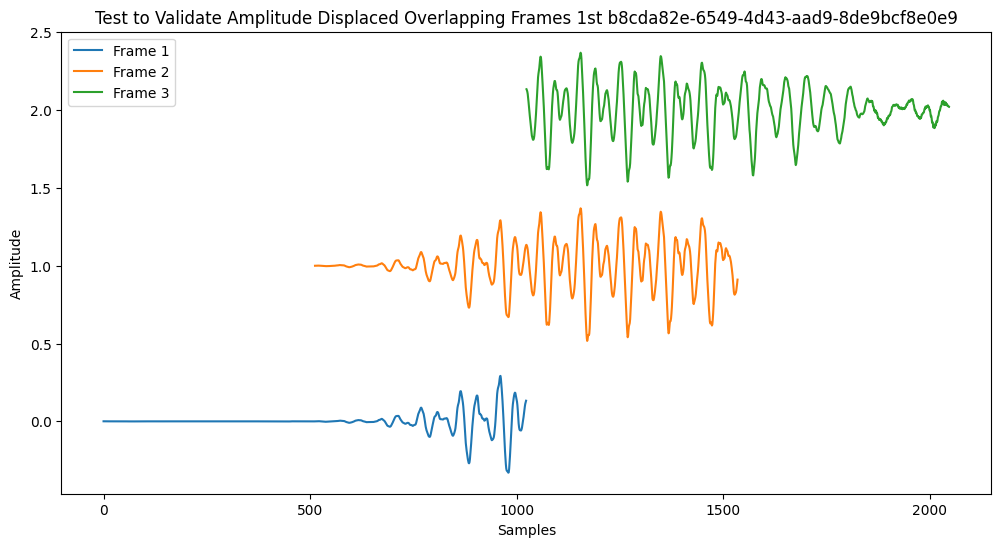

Hop Length: 512


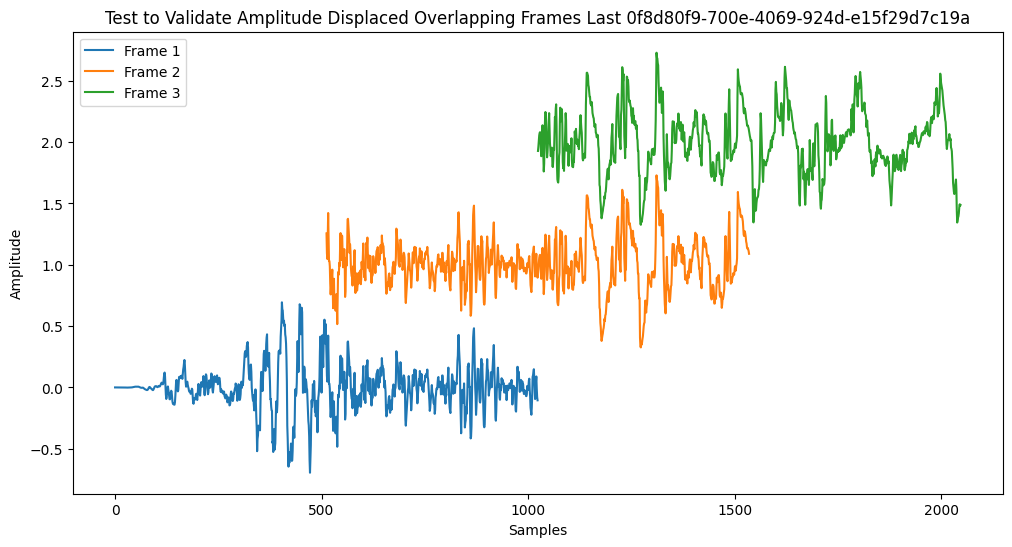

In [8]:
all_frames_from_save = frame.apply_framing(audio_df=df_from_save, frame_sizes=[1024,2048])
df_frame_from_save = all_frames_from_save[1024]
df_frame_from_save.head(3)

visual_set = {"1st":df_frame_from_save.head(1)["key"].values[0],"Last":df_frame_from_save.tail(1)["key"].values[0]}
frame.visualize_overlapping_frames(title='Test to Validate Amplitude Displaced Overlapping Frames', framed_df=df_frame_from_save, visual_set=visual_set)

# Feature Extraction

## Spectogram
- Execution Time: Aproximately 2 minutes

In [9]:
from feature_extraction import Spectrogram
spectrogram = Spectrogram()
#help(ffe)

In [10]:
frame_size = 1024

obs = 64  #The number of frequency bins in the output (output bin size - obs)

n_fft = (obs * 2) - 1   #sub-frame size
win_length = n_fft  #apply windowing function to the entire length of the frame

hop_percent = 50
hop_length = (n_fft + 1) * hop_percent // 100

df_1024_spectrogram = spectrogram.get_spectogram_dataset(
    frame_size=frame_size,
    frames_dic=all_frames_from_save,
    limit=0,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    use_gpu=False
)

# save dataset in cache / temp storage, it helps to free up memory when fully implemented
spectrogram.save_spectogram_data(df=df_1024_spectrogram, file_name=frame_size, dir='', temporary=True)

#visualize only 1 spectogram for confirmation
key = 411
spectrogram.plot_spectrogram( file_name=df_1024_spectrogram['key'][key], S_DB=np.array(df_1024_spectrogram['stft'][key]), sr=df_1024_spectrogram['sf'][key], hop_length=64 )
print('shape of stft', df_1024_spectrogram['stft'][key].shape )
print('shape of the frame', df_1024_spectrogram['amp'][key].shape )

df_1024_spectrogram[ df_1024_spectrogram['key'] == '9821da28-7655-4736-abf8-4c89582e407f' ]

starting: 1024
using n_fft:127, hop length:64, win_length:127


shape of stft (64, 16)
shape of the frame (1024,)


key     sf   start     end   max_amp  \
79515  9821da28-7655-4736-abf8-4c89582e407f  16000       0    1024  0.000260   
79516  9821da28-7655-4736-abf8-4c89582e407f  16000     512    1536  0.000527   
79517  9821da28-7655-4736-abf8-4c89582e407f  16000    1024    2048  0.000737   
79518  9821da28-7655-4736-abf8-4c89582e407f  16000    1536    2560  0.000922   
79519  9821da28-7655-4736-abf8-4c89582e407f  16000    2048    3072  0.000922   
...                                     ...    ...     ...     ...       ...   
79810  9821da28-7655-4736-abf8-4c89582e407f  16000  151040  152064  0.000035   
79811  9821da28-7655-4736-abf8-4c89582e407f  16000  151552  152576  0.000057   
79812  9821da28-7655-4736-abf8-4c89582e407f  16000  152064  153088  0.000057   
79813  9821da28-7655-4736-abf8-4c89582e407f  16000  152576  153600  0.000062   
79814  9821da28-7655-4736-abf8-4c89582e407f  16000  153088  154112  0.000062   

       frame_index                                                amp  label  \
79515            0  [2.4100282e-19, 4.552187e-20, -4.743169e-19, -...      0   
79516            1  [-2.2809586e-13, 2.4235616e-13, -2.5261767e-13...      0   
79517            2  [5.5891054e-05, 0.00021803637, 0.00024021938, ...      0   
79518            3  [1.42881745e-05, -3.4426583e-05, 2.6231002e-05...      0   
79519            4  [0.0008490162, 0.0005570182, 0.00032274745, 0....      0   
...            ...                                                ...    ...   
79810          295  [-7.700891e-08, -1.1894869e-08, 8.98313e-08, -...      0   
79811          296  [2.8354348e-06, 2.6322938e-05, 2.7386598e-06, ...      0   
79812          297  [-1.4644161e-06, 2.2830393e-06, -5.1760608e-06...      0   
79813          298  [-7.7346846e-07, 4.2284967e-09, 6.061488e-07, ...      0   
79814          299  [-2.2275498e-07, -2.6175371e-08, 1.9698385e-07...      0   

                                                    stft  
79515  [[-51.059193, -51.059193, -51.059193, -51.0591...  
79516  [[-58.507927, -58.507927, -58.507927, -58.5079...  
79517  [[-18.885334, -32.74474, -24.695766, -35.10622...  
79518  [[-11.560276, -21.754932, -18.039566, -18.9115...  
79519  [[-28.875217, -18.529537, -17.38078, -24.56908...  
...                                                  ...  
79810  [[-6.08123, -14.986046, -11.597763, -18.588615...  
79811  [[-19.990303, -18.756165, -19.800034, -8.37455...  
79812  [[-4.9242554, -31.57219, -7.556259, -15.962433...  
79813  [[-27.41166, -6.1541214, -8.564682, -11.30648,...  
79814  [[-20.347221, -12.880432, -19.409653, -17.7206...  

[300 rows x 9 columns]

# Model Training

In [11]:
df_1024_spectrogram.shape

(82957, 9)

## CNN - Source: Breanne Code
- Modified Cross Validation to ensure that frames from training audio recording are not contained in test recording
- Modified for Spectogram
- Reference: https://cseegit.essex.ac.uk/23-24-ce903-su/23-24_CE903-SU_team06/-/blob/feature-extraction-mel-spectrogram/notebooks/Feature_extraction_mel_spectrogram.ipynb



In [12]:
!pip install imbalanced-learn

In [13]:
#14-Jun-24: no longer necessary at this point, moved after cross val has been completed
# spectrograms = np.array([spec.reshape(64, 16, 1) for spec in df_1024_spectogram['stft']])
# spectrograms.shape

## Split Data into Train and Test Set
- 20% test set

In [14]:
no_cough_class = df_from_save['cough_start_end'].isna()
no_cough_class

key
b8cda82e-6549-4d43-aad9-8de9bcf8e0e9     True
b9408db9-881b-4a95-ba6c-ac51602955a6     True
e9bf0a5a-ff96-480b-a54a-f647143e1d6f    False
e4729edf-12e5-4ba9-883e-1114c32b90f0    False
4c2840ed-fd4b-4a86-b976-5cc040d6ea4e    False
                                        ...  
48b287c0-5c2b-44ef-b469-3808b3b287ea    False
52f6838a-4033-4a71-84bb-81cbb4e64ab7    False
7a8bd218-252f-4d84-a035-0d3262efa825     True
9d539eb5-62de-4d5d-994b-866238ecd96e     True
0f8d80f9-700e-4069-924d-e15f29d7c19a    False
Name: cough_start_end, Length: 300, dtype: bool

In [15]:
from sklearn.model_selection import train_test_split

test_size = 0.2
# Perform train-test split
X_train_nocough, X_test_nocough = train_test_split(df_from_save[no_cough_class==True].index, test_size=test_size, random_state=42)

X_train_cough, X_test_cough = train_test_split(df_from_save[no_cough_class==False].index, test_size=test_size, random_state=42)

# Display the results
print("X_train_nocough:", X_train_nocough.shape)
print("X_test_nocough:", X_test_nocough.shape)
print("X_train_cough:", X_train_cough.shape)
print("X_test_cough:", X_test_cough.shape)


X_train_nocough: (120,)
X_test_nocough: (30,)
X_train_cough: (120,)
X_test_cough: (30,)


In [16]:
# merge train set (cough + nocough)
len(list(X_train_cough) + list(X_train_nocough))

240

## Cross val with 80% train set

In [17]:
# Get Train Set
# adaptation due to of time limitation
df_1024_spectrogram.head(3)
# df_1024_spectogram[ df_1024_spectogram['key'].isin( list(X_train_cough) + list(X_train_nocough) ) ].head(3)

key     sf  start   end   max_amp  \
0  b8cda82e-6549-4d43-aad9-8de9bcf8e0e9  16000      0  1024  0.006137   
1  b8cda82e-6549-4d43-aad9-8de9bcf8e0e9  16000    512  1536  0.023188   
2  b8cda82e-6549-4d43-aad9-8de9bcf8e0e9  16000   1024  2048  0.074459   

   frame_index                                                amp  label  \
0            0  [1.6998944e-11, 1.6948607e-11, -3.3269082e-11,...      0   
1            1  [-0.00024980583, -0.00026363018, -0.0002713691...      0   
2            2  [-0.0018562947, -0.0023917924, -0.0028657983, ...      0   

                                                stft  
0  [[-80.0, -80.0, -80.0, -80.0, -38.62269, -34.8...  
1  [[-73.59495, -47.903156, -48.333363, -37.50980...  
2  [[-37.807816, -28.536388, -28.100117, -35.3743...

Sono Cross Val Split
 StratifiedKFold(n_splits=5, random_state=6, shuffle=True) 	Total Audio Files: 300


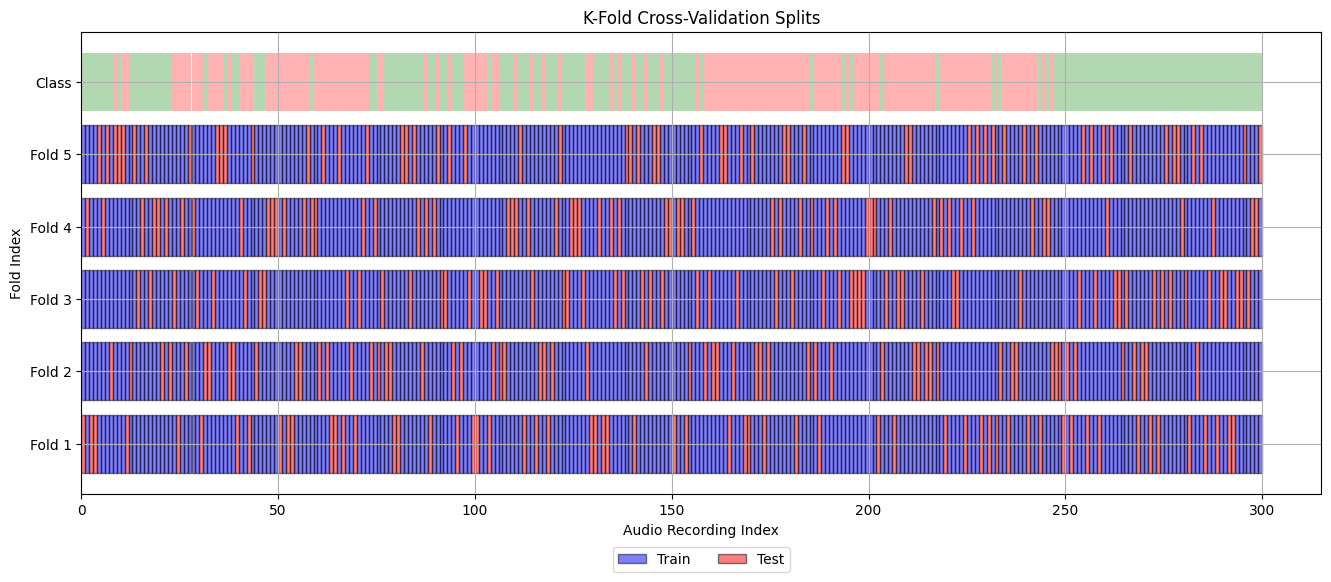

In [18]:
from sono_cross_val import CrossValSplit
# cv_strat = CrossValSplit(df_single_frame=df_1024_spectrogram[ df_1024_spectogram['key'].isin( list(X_train_cough) + list(X_train_nocough) ) ], non_cough_keys=X_train_nocough)
# adaptation due to of time limitation
cv_strat = CrossValSplit(df_single_frame=df_1024_spectrogram, non_cough_keys=df_from_save[no_cough_class==True].index)

cv_strat_data = cv_strat.cross_val(stratified=True, shuffle=True, plot=True, show_fold_info=False)

In [19]:
df_1024_spectrogram.loc[cv_strat_data[1][0]]

key     sf   start     end   max_amp  \
64     b9408db9-881b-4a95-ba6c-ac51602955a6  16000       0    1024  0.020692   
65     b9408db9-881b-4a95-ba6c-ac51602955a6  16000     512    1536  0.024697   
66     b9408db9-881b-4a95-ba6c-ac51602955a6  16000    1024    2048  0.037222   
67     b9408db9-881b-4a95-ba6c-ac51602955a6  16000    1536    2560  0.058464   
68     b9408db9-881b-4a95-ba6c-ac51602955a6  16000    2048    3072  0.058464   
...                                     ...    ...     ...     ...       ...   
82234  52f6838a-4033-4a71-84bb-81cbb4e64ab7  16000  155136  156160  0.000000   
82235  52f6838a-4033-4a71-84bb-81cbb4e64ab7  16000  155648  156672  0.000000   
82236  52f6838a-4033-4a71-84bb-81cbb4e64ab7  16000  156160  157184  0.000000   
82237  52f6838a-4033-4a71-84bb-81cbb4e64ab7  16000  156672  157696  0.000000   
82238  52f6838a-4033-4a71-84bb-81cbb4e64ab7  16000  157184  158208  0.000000   

       frame_index                                                amp  label  \
64               0  [5.813955e-10, -7.632952e-10, -1.9169968e-09, ...      0   
65               1  [-0.008925999, -0.0088388845, -0.008110482, -0...      0   
66               2  [0.002205449, 0.004359279, 0.0070404857, -0.00...      0   
67               3  [0.00276856, 0.0051492443, 0.0020777467, 0.006...      0   
68               4  [0.03539607, 0.008230816, 0.030858662, 0.03123...      0   
...            ...                                                ...    ...   
82234          303  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0   
82235          304  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0   
82236          305  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0   
82237          306  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0   
82238          307  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0   

                                                    stft  
64     [[-80.0, -53.89815, -16.729425, -33.24511, -27...  
65     [[-28.432638, -35.969894, -53.538185, -29.2426...  
66     [[-21.25454, -36.74861, -42.625774, -56.406517...  
67     [[-26.975864, -47.94633, -59.09713, -46.44738,...  
68     [[-20.26377, -59.800804, -43.535755, -43.95144...  
...                                                  ...  
82234  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
82235  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
82236  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
82237  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
82238  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  

[68044 rows x 9 columns]

In [37]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf


#14-Jun-24: no longer necessary at this point, moved after cross val has been completed
# Bring in mel-spectrogram from dataframe created above, put it in expected size
#mel_spectrograms = np.array([mel_spec.reshape(64, 16, 1) for mel_spec in audio_df_with_mel_spectrograms['mel']])
#mel_spectrograms = spectrograms

# Bring in labels (cough (1) vs non-cough (0))
# labels = np.array(df_1024_spectogram['label'])

# Define the model architecture
def cough_detection_model(input_shape):
    """
    Creates a CNN model for cough detection.

    Args:
        input_shape: A tuple representing the shape of the input data (e.g., (64, 16, 1)).

    Returns:
        A compiled Keras model.
    """

    # Input layer
    inputs = keras.Input(shape=input_shape)

    # First convolutional layer
    x = layers.Conv2D(16, kernel_size=(9, 3), activation="relu")(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)

    # Second convolutional layer
    x = layers.Conv2D(16, kernel_size=(5, 3), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)

    # Flatten the output of convolutional layers
    x = layers.Flatten()(x)

    # First fully-connected layer with dropout
    x = layers.Dense(256, activation="relu")(x)
    #x = layers.Dropout(0.25)(x)  # Dropout with probability 0.5

    # Second fully-connected layer with dropout
    x = layers.Dense(256, activation="relu")(x)
    #x = layers.Dropout(0.25)(x)  # Dropout with probability 0.5

    # Output layer with softmax activation
    outputs = layers.Dense(1, activation="sigmoid")(x)

    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    #loss="binary_crossentropy"
    #loss=custom_loss
    model.compile(loss="binary_crossentropy", optimizer=optimizer,
        metrics=[
                "accuracy",
                metrics.Precision(name='precision'),
                metrics.Recall(name='recall'),
                metrics.AUC(name='auc_roc', curve='ROC'),
                metrics.AUC(name='auc_pr', curve='PR'),
                metrics.TruePositives(name='true_positives'),
                metrics.FalsePositives(name='false_positives'),
                metrics.TrueNegatives(name='true_negatives'),
                metrics.FalseNegatives(name='false_negatives'),
                metrics.FBetaScore(name='f1_score', beta=1.0)
    ])

    return model

def custom_loss(y_true, y_pred):
    false_positives = tf.reduce_sum((1 - y_true) * y_pred)
    false_negatives = tf.reduce_sum(y_true * (1 - y_pred))

    # Assign higher weight to false positives
    weight_fp = 1.2  # Adjust this weight as needed
    weight_fn = 1.1

    # Binary cross-entropy loss
    bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)

    # Combined loss
    combined_loss = bce_loss + (weight_fp * false_positives) + (weight_fn * false_negatives)
    return combined_loss

# 14-Jun-24: Not being used
# Compute class weights
# class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
# class_weights = dict(enumerate(class_weights))
# print("Class weights:", class_weights)


In [62]:
batch_size = 784
epochs = 10

Start Epoch (Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       82947, 82948, 82949, 82950, 82951, 82952, 82953, 82954, 82955, 82956],
      dtype='int64', length=63315), Index([   64,    65,    66,    67,    68,    69,    70,    71,    72,    73,
       ...
       81005, 81006, 81007, 81008, 81009, 81010, 81011, 81012, 81013, 81014],
      dtype='int64', length=19642))
Epoch 1/10
145/145 [==============================] - 6s 21ms/step - loss: 0.8241 - accuracy: 0.7567 - precision: 0.7512 - recall: 0.7676 - auc_roc: 0.8185 - auc_pr: 0.7714 - true_positives: 43356.0000 - false_positives: 14361.0000 - true_negatives: 42122.0000 - false_negatives: 13127.0000 - f1_score: 0.6642 - val_loss: 0.6609 - val_accuracy: 0.6769 - val_precision: 0.2099 - val_recall: 0.8097 - val_auc_roc: 0.8183 - val_auc_pr: 0.3343 - val_true_positives: 1587.0000 - val_false_positives: 5973.0000 - val_true_negatives: 11709.0000 - val_false_negatives: 373.0000 - val_f1_scor

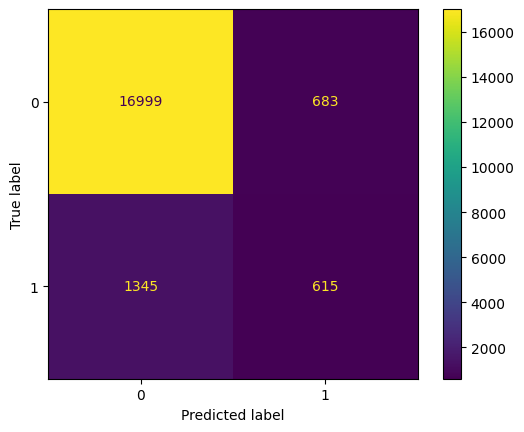

Start Epoch (Index([   64,    65,    66,    67,    68,    69,    70,    71,    72,    73,
       ...
       82229, 82230, 82231, 82232, 82233, 82234, 82235, 82236, 82237, 82238],
      dtype='int64', length=68044), Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       82947, 82948, 82949, 82950, 82951, 82952, 82953, 82954, 82955, 82956],
      dtype='int64', length=14913))
Epoch 1/10
156/156 [==============================] - 5s 19ms/step - loss: 0.7834 - accuracy: 0.7926 - precision: 0.7832 - recall: 0.8091 - auc_roc: 0.8590 - auc_pr: 0.8157 - true_positives: 49401.0000 - false_positives: 13671.0000 - true_negatives: 47388.0000 - false_negatives: 11658.0000 - f1_score: 0.6637 - val_loss: 0.3543 - val_accuracy: 0.8422 - val_precision: 0.4104 - val_recall: 0.6934 - val_auc_roc: 0.8780 - val_auc_pr: 0.4578 - val_true_positives: 1253.0000 - val_false_positives: 1800.0000 - val_true_negatives: 11306.0000 - val_false_negatives: 554.0000 - val_f1_scor

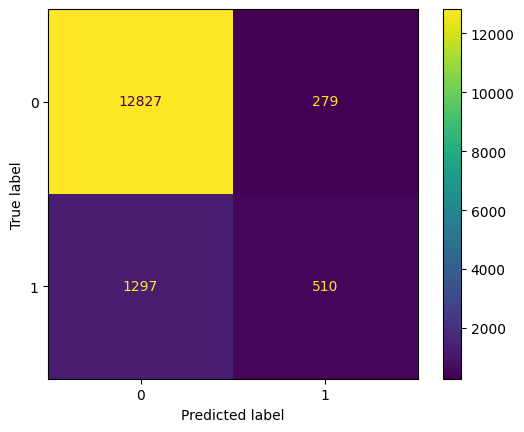

Start Epoch (Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       82947, 82948, 82949, 82950, 82951, 82952, 82953, 82954, 82955, 82956],
      dtype='int64', length=69040), Index([  687,   688,   689,   690,   691,   692,   693,   694,   695,   696,
       ...
       81619, 81620, 81621, 81622, 81623, 81624, 81625, 81626, 81627, 81628],
      dtype='int64', length=13917))
Epoch 1/10
159/159 [==============================] - 5s 18ms/step - loss: 0.6399 - accuracy: 0.7284 - precision: 0.7173 - recall: 0.7541 - auc_roc: 0.7965 - auc_pr: 0.7586 - true_positives: 46784.0000 - false_positives: 18441.0000 - true_negatives: 43598.0000 - false_negatives: 15255.0000 - f1_score: 0.6667 - val_loss: 0.5600 - val_accuracy: 0.6682 - val_precision: 0.2566 - val_recall: 0.8319 - val_auc_roc: 0.8258 - val_auc_pr: 0.4255 - val_true_positives: 1490.0000 - val_false_positives: 4316.0000 - val_true_negatives: 7810.0000 - val_false_negatives: 301.0000 - val_f1_score

Start Epoch (Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       82947, 82948, 82949, 82950, 82951, 82952, 82953, 82954, 82955, 82956],
      dtype='int64', length=63593), Index([ 3101,  3102,  3103,  3104,  3105,  3106,  3107,  3108,  3109,  3110,
       ...
       81921, 81922, 81923, 81924, 81925, 81926, 81927, 81928, 81929, 81930],
      dtype='int64', length=19364))
Epoch 1/10
145/145 [==============================] - 6s 19ms/step - loss: 0.4360 - accuracy: 0.8187 - precision: 0.8102 - recall: 0.8323 - auc_roc: 0.8942 - auc_pr: 0.8867 - true_positives: 47099.0000 - false_positives: 11031.0000 - true_negatives: 45558.0000 - false_negatives: 9490.0000 - f1_score: 0.6667 - val_loss: 0.4626 - val_accuracy: 0.8010 - val_precision: 0.2751 - val_recall: 0.7069 - val_auc_roc: 0.8456 - val_auc_pr: 0.3368 - val_true_positives: 1264.0000 - val_false_positives: 3330.0000 - val_true_negatives: 14246.0000 - val_false_negatives: 524.0000 - val_f1_score

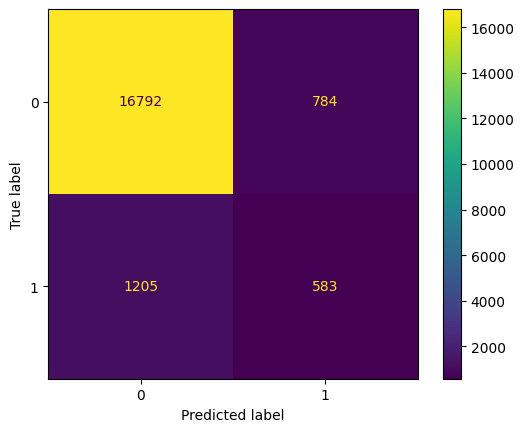

Start Epoch (Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       82947, 82948, 82949, 82950, 82951, 82952, 82953, 82954, 82955, 82956],
      dtype='int64', length=67836), Index([  128,   129,   130,   131,   132,   133,   134,   135,   136,   137,
       ...
       82229, 82230, 82231, 82232, 82233, 82234, 82235, 82236, 82237, 82238],
      dtype='int64', length=15121))
Epoch 1/10
155/155 [==============================] - 6s 21ms/step - loss: 0.6855 - accuracy: 0.7524 - precision: 0.7495 - recall: 0.7581 - auc_roc: 0.8203 - auc_pr: 0.7757 - true_positives: 45859.0000 - false_positives: 15328.0000 - true_negatives: 45162.0000 - false_negatives: 14631.0000 - f1_score: 0.6667 - val_loss: 0.3984 - val_accuracy: 0.8282 - val_precision: 0.3163 - val_recall: 0.6860 - val_auc_roc: 0.8544 - val_auc_pr: 0.3777 - val_true_positives: 992.0000 - val_false_positives: 2144.0000 - val_true_negatives: 11531.0000 - val_false_negatives: 454.0000 - val_f1_score

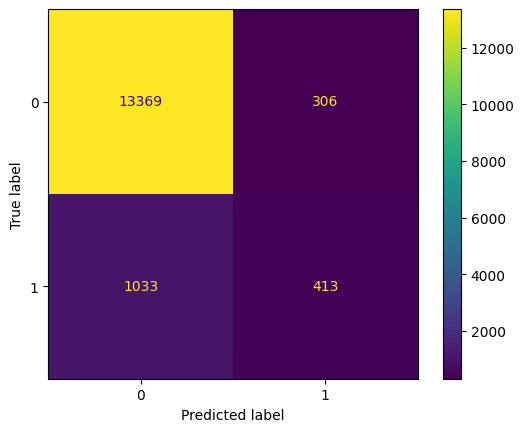

In [63]:
# Placeholder for metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
auc_roc_scores = []
aucs = []
auc_pr_scores = []
confusion_m = []
auc_prs = []

# For plotting ROC curve
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

# 14-Jun-24: Modification to use Cross Val
# Split into train and validation sets
for fold in cv_strat_data:
    print(f"Start Epoch {fold}")
    train_set = df_1024_spectrogram.loc[fold[0]]
    val_set = df_1024_spectrogram.loc[fold[1]]

    X_train = np.array([spec.reshape(64, 16, 1) for spec in train_set['stft']])
    X_val = np.array([spec.reshape(64, 16, 1) for spec in val_set['stft']])
    y_train, y_val = train_set['label'].values, val_set['label'].values

    #print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

    # Apply SMOTE for oversampling the minority class in training data
    X_train_2d = X_train.reshape(X_train.shape[0], -1)
    smote = SMOTE()
    X_train_resampled_2d, y_train_resampled = smote.fit_resample(X_train_2d, y_train)

    # Reshape the oversampled training data back to 3D
    X_train_resampled = X_train_resampled_2d.reshape(-1, 64, 16, 1)

    # Apply SMOTE for oversampling the minority class in validation data
    X_val_2d = X_val.reshape(X_val.shape[0], -1)
    X_val_resampled_2d, y_val_resampled = smote.fit_resample(X_val_2d, y_val)

    # Reshape the oversampled validation data back to 3D
    X_val_resampled = X_val_resampled_2d.reshape(-1, 64, 16, 1)

    # Convert labels to float32
    #X_train_resampled = X_train_resampled.astype('float32')
    #X_val = X_val.astype('float32')
    y_train_resampled = y_train_resampled.astype('float32')
    y_val = y_val.astype('float32')

    # Define input shape
    model = cough_detection_model(input_shape=(64, 16, 1))
    #model.summary()

    # Fit the model
    model.fit(X_train_resampled, y_train_resampled, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=1)

    # Evaluate the model
    y_pred = model.predict(X_val)
    y_pred_classes = (y_pred > 0.875).astype(int)

    ac = accuracy_score(y_val, y_pred_classes)
    accuracy_scores.append(ac)

    pc = precision_score(y_val, y_pred_classes)
    precision_scores.append(pc)

    rc = recall_score(y_val, y_pred_classes)
    recall_scores.append(rc)

    ff = f1_score(y_val, y_pred_classes)
    f1_scores.append(ff)

    auc_roc = roc_auc_score(y_val, y_pred)
    auc_roc_scores.append(auc_roc)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    auc = roc_auc_score(y_val, y_pred)
    aucs.append(auc)

    #auc_roc_scores.append(model.evaluate(X_val, y_val, verbose=0)[4])
    #auc_pr_scores.append(model.evaluate(X_val, y_val, verbose=0)[5])

    # Print confusion matrix for current fold
    cm = confusion_matrix(y_val, y_pred_classes, labels=[0,1])
    confusion_m.append(cm)
    print("Test Values")
    print("Accuracy", ac, "Precision", pc, "Recall", rc, "F1 Score", ff, "AUC ROC", auc_roc)

    print("Confusion Matrix for current fold:")
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[0,1])
    disp.plot()
    plt.show()


# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance')

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='blue', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


2 fold cross validation, 10 Epoch, avg. time per epoch 2mins (53.2ms/step) training time 20mins, testing time

In [9]:
# Save the trained model
# Define the desired path
desired_path = f'/content/drive/My Drive/{GDRIVE_MODEL_DIR}'

# Construct the full file path
model_path = f"/content/drive/My Drive/{GDRIVE_MODEL_DIR}cnn_model_spectrogram_875_batch{batch_size}_epoch{epochs}.h5"

# Create the directory if it doesn't exist
os.makedirs(desired_path, exist_ok=True)

# Save model
model.save(model_path)
print(f"Model saved to '{model_path}'")

NameError: name 'batch_size' is not defined

In [65]:
dfc = {
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1': f1_scores,
    'AUC ROC': auc_roc_scores,
    #'AUC PR': auc_pr_scores,
    'Confusion Matrix':[i.tolist() for i in confusion_m]
}
dfr = pd.DataFrame(dfc)
dfr.to_feather(f'{desired_path}cnn_model_spectrogram_875_batch{batch_size}_epoch{epochs}.feather')

In [66]:
dfr

Accuracy  Precision    Recall        F1   AUC ROC  \
0  0.896752   0.473806  0.313776  0.377532  0.809364   
1  0.894320   0.646388  0.282236  0.392912  0.863007   
2  0.889344   0.620096  0.361809  0.456982  0.875043   
3  0.897284   0.426481  0.326063  0.369572  0.812820   
4  0.911448   0.574409  0.285615  0.381524  0.834766   

              Confusion Matrix  
0  [[16999, 683], [1345, 615]]  
1  [[12827, 279], [1297, 510]]  
2  [[11729, 397], [1143, 648]]  
3  [[16792, 784], [1205, 583]]  
4  [[13369, 306], [1033, 413]]

In [10]:
import os
feather_files = [f for f in os.listdir(desired_path) if f.endswith('.feather')]
feather_files

dxf = {"Model":[], "Acc":[], "Recall":[], "Precision":[], "F1":[], "AUC ROC":[]}
for x in feather_files:
 # print(x)
  dx = pd.read_feather(f'{desired_path}{x}')

  #print( dx.columns )
  if 'auc_roc' in dx.columns:
    cl = 'auc_roc'
  elif 'AUC ROC' in dx.columns:
    cl = 'AUC ROC'
  else:
    continue
  if 'accuracy' in dx.columns:
    cla = 'accuracy'
  elif 'Accuracy' in dx.columns:
    cla = 'Accuracy'
  else:
    continue
  if 'Recall' in dx.columns:
    clr = 'Recall'
  elif 'recall' in dx.columns:
    clr = 'recall'
  else:
    continue

  dxf["Model"].append( x.replace('_training_results', '').replace('_default_params', '').replace('.feather', '').replace('_model_', '_').replace('_domain', '') )
  dxf["Acc"].append( dx[cla].mean() )
  dxf["Recall"].append( dx[clr].mean() )
  dxf["Precision"].append( dx[clr].mean() )
  dxf["F1"].append( dx[clr].mean() )
  dxf["AUC ROC"].append( dx[cl].mean() )
  #print( dx[cl].mean() )

dgx = pd.DataFrame(dxf)
sorted_df = dgx.sort_values(by=['AUC ROC', 'F1', 'Acc'], ascending=[False, False, False])
sorted_df

Model       Acc    Recall  Precision  \
17                         logistic_time_freq  0.921754  0.527573   0.527573   
18                   logistic_tuned_time_freq  0.921754  0.527573   0.527573   
6                    logistic_grid2_time_freq  0.921754  0.527573   0.527573   
5                     logistic_grid_time_freq  0.921740  0.527011   0.527011   
2            cnn_spectrogram_batch512_epoch10  0.862985  0.589152   0.589152   
21  cnn_spectrogram_drop25_5_batch784_epoch10  0.882451  0.454150   0.454150   
20  cnn_spectrogram_drop25_7_batch784_epoch10  0.890648  0.383976   0.383976   
12        cnn_melspectrogram_batch784_epoch10  0.890603  0.468874   0.468874   
25       cnn_spectrogram_875_batch784_epoch10  0.897829  0.313900   0.313900   
1            cnn_spectrogram_batch128_epoch10  0.890901  0.421897   0.421897   
24       cnn_spectrogram_125_batch784_epoch10  0.864302  0.557062   0.557062   
23         cnn_spectrogram_5_batch784_epoch10  0.877013  0.486484   0.486484   
4         cnn_melspectrogram_batch512_epoch10  0.885203  0.510222   0.510222   
15        cnn_melspectrogram_batch784_epoch15  0.885467  0.480315   0.480315   
16        cnn_melspectrogram_batch784_epoch12  0.888956  0.438089   0.438089   
22         cnn_spectrogram_5_batch784_epoch60  0.892849  0.411241   0.411241   
14       cnn_melspectrogram_batch1024_epoch20  0.889209  0.484994   0.484994   
13        cnn_melspectrogram_batch784_epoch25  0.897014  0.458577   0.458577   
7                           xgboost_time_freq  0.925463  0.609368   0.609368   
19                 randomforest_hyp_time_freq  0.930669  0.601486   0.601486   
10                             lgbm_time_freq  0.928796  0.600529   0.600529   
0           cnn_spectrogram_batch256_epoch100  0.896819  0.391799   0.391799   
9                      randomforest_time_freq  0.930462  0.571116   0.571116   
11       cnn_melspectrogram_batch1024_epoch50  0.893006  0.455192   0.455192   
8                               svc_time_freq  0.927987  0.559928   0.559928   
3            cnn_spectrogram_batch128_epoch30  0.887376  0.416139   0.416139   

          F1   AUC ROC  
17  0.527573  0.928552  
18  0.527573  0.928552  
6   0.527573  0.928549  
5   0.527011  0.928502  
2   0.589152  0.869372  
21  0.454150  0.855138  
20  0.383976  0.854193  
12  0.468874  0.844739  
25  0.313900  0.839000  
1   0.421897  0.838568  
24  0.557062  0.831358  
23  0.486484  0.826734  
4   0.510222  0.817136  
15  0.480315  0.809343  
16  0.438089  0.808729  
22  0.411241  0.805003  
14  0.484994  0.801681  
13  0.458577  0.787921  
7   0.609368  0.786529  
19  0.601486  0.785913  
10  0.600529  0.784390  
0   0.391799  0.773575  
9   0.571116  0.772378  
11  0.455192  0.767394  
8   0.559928  0.766216  
3   0.416139  0.750269